In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import beta
import scipy.special

%matplotlib inline

## Generate NegBin data

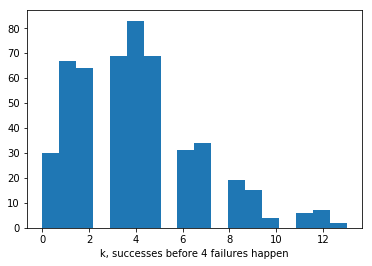

In [2]:
N = 500 # size of toy data
alp = 2. 
bet = 2.
true_mu = .5

# the NB is defined for a fixed number of failures, r. 
# It describes the distribution of successes until r failures have occured, or the other way around. 
# thus, the number of trials is implicit 
n_failures = 4

X_o = np.random.negative_binomial(n=n_failures, p=true_mu, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))

plt.hist(X_o, bins='auto');
plt.xlabel('k, successes before {} failures happen'.format(n_failures));

## Derive posterior over $\mu$ with a Beta prior

The likelihood for observing $x_i$ successes with a success probability of $\mu$ before $M$ failures occurred when drawing $N$ times is given by the negbin pdf 

$$
p(x| \mu) = \prod_{i=1}^N {{x_i + M - 1}\choose{x_i}} (1 - \mu)^{M}\mu^{x_i}. 
$$

The conjugtae prior for $\mu$ is the Beta distribution 

$$
p(\mu) = Beta(\alpha, \beta) = \frac{\mu^{\alpha - 1} (1 - \mu)^{\beta - 1}}{B(\alpha, \beta)}
$$

The marginal likelihood is given by 

$$
E = \int p(x | \mu) p(\mu) d\mu = \frac{B(\alpha + \sum x_i, \beta + NM)}{B(\alpha, \beta)}\prod_{i=1}^N {{x_i + M - 1}\choose{x_i}}
$$

Thus, the posterior is given by 

$$
p(\mu | x) = \frac{p(x| \mu)p(\mu) }{\int p(x | \mu) p(\mu) d\mu} = \frac{\prod_{i=1}^N {{x_i + M - 1}\choose{x_i}} (1 - \mu)^{M}\mu^{x_i}\frac{\mu^{\alpha - 1} (1 - \mu)^{\beta - 1}}{B(\alpha, \beta)}}{\frac{B(\alpha + \sum x_i, \beta + NM)}{B(\alpha, \beta)}\prod_{i=1}^N {{x_i + M - 1}\choose{x_i}}} = \frac{(1-\mu)^{NM + \beta -1}\mu^{\sum x_i + \alpha - 1}}{B(\alpha + \sum x_i, \beta + NM)} = Beta(\alpha + \sum x_i, \beta + NM)
$$

In [3]:
# hard coded function for calculating the posterior and evidence separately. 
# The result is somehow not normalized so there might be a bug or varying definitions of the negbin in 
# numpy.random or scipy.stats 

def posterior(mu, ks, alpha, beta, log=True): 
    N = ks.size
    M = n_failures
    s1 = np.sum(scipy.special.binom(ks + M - 1, ks))
    s2 = (N*M + beta - 1) * np.log(1 - mu)
    s3 = (np.sum(ks) + alpha - 1)*np.log(mu)
    s4 = - scipy.special.betaln(alpha, beta)
    result = s1 + s2 + s3 + s4
    return result if log else np.exp(result)

def log_nbin_evidence(x, alpha, beta): 
    N = x.size
    M = n_failures
    s1 = scipy.special.betaln(alpha + x.sum(), beta + N * M)
    s2 = -scipy.special.betaln(alpha, beta)
    s3 = np.sum(np.log(scipy.special.binom(x + M - 1, x)))
    return s1 + s2 + s3

## Learn MDN to predict the posterior over $\mu$ 

The MDN has to approximate a Beta distribution. Thus, the output should be the shape and scale parameters of the Beta distribution. The sufficient statistics for the negative binomial is just $x$ and for many samples just the sum $\sum x_i$. 

In [4]:
# The cost function of the MDN needs to evaluate the beta distribution written in pytorch terms: 

def log_gamma(xx):
    gamma_coeff = [
        76.18009172947146,
        -86.50532032941677,
        24.01409824083091,
        -1.231739572450155,
        0.1208650973866179e-2,
        -0.5395239384953e-5,
    ]
    magic1 = 1.000000000190015
    magic2 = 2.5066282746310005
    x = xx - 1.0
    t = x + 5.5
    t = t - (x + 0.5) * torch.log(t)
    ser = Variable(torch.ones(x.size()) * magic1)
    for c in gamma_coeff:
        x = x + 1.0
        ser = ser + torch.pow(x / c, -1)
    return torch.log(ser * magic2) - t

def log_betafun(a, b): 
    return log_gamma(a) + log_gamma(b) - log_gamma(a + b)

def beta_pdf(y, out_shape, out_scale, log=True): 
    # beta function is defined in terms of gamma as: B(a, b) = gamma(a)gamma(b)/gamma(a + b)
    one = Variable(torch.ones(x.size()).type_as(alpha.data))
    result = (a - 1) * torch.log(mu) + (b - 1) * torch.log(1 - mu) - log_betafun(a, b)
    return result if log else np.exp(result)

In [5]:
class MDN_phi(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN_phi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.scale_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())
        self.shape_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_shape = self.scale_out(act)
        out_scale = self.shape_out(act)
        return (out_shape, out_scale)

# the loss evaluates model (MoG) with the given data (y) and takes the log loss
def mdn_loss_function(out_shape, out_scale, y):
    result = gamma_pdf(y, out_shape, out_scale, log=True)
    result = torch.mean(result)  # mean over batch
    return -result

def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys
        
def train(X, Y, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_shape, out_scale) = model(x_var)
            loss = mdn_loss_function(out_shape, out_scale, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))

## Plot the predictive and the analystical posterior over the whole range of mus 

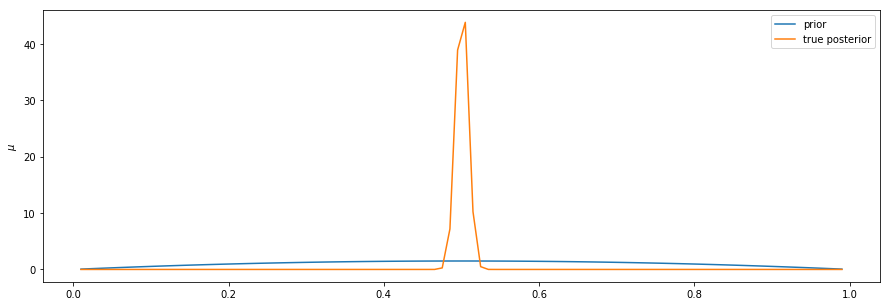

In [6]:
N = X_o.size 
M = n_failures

# analytical posterior 
mus = np.linspace(0.01, 0.99, 100)

prior = beta.pdf(mus, alp, bet)

a = alp + X_o.sum()
b = bet + N * M
post_ana = beta.pdf(mus, a, b)

# plotting 
plt.figure(figsize=(15, 5))
plt.plot(mus, prior, label='prior')
plt.plot(mus, post_ana, label='true posterior')
plt.ylabel(r'$\mu$')
plt.legend(); 